# Transfer learning!

- caltech-256
- we use only 10 classes
- ResNet-50

## Import necessary packages

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from dataclasses import dataclass

import torchvision
from torchvision import transforms, datasets, models
from torchinfo import summary
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from urllib.request import urlretrieve
import zipfile

plt.style.use('ggplot')


## Download and Extract the caltech256 Subset Dataset

In [4]:
def download_and_unzip(url, save_path):
    urlretrieve(url, save_path)
    with zipfile.ZipFile(save_path, 'r') as zip_ref:
        zip_ref.extractall(save_path.replace('.zip', ''))
    os.remove(save_path)

URL = 'https://www.dropbox.com/s/0ltu2bsja3sb2j4/caltech256_subset.zip?dl=1'
file_name = 'caltech256_subset.zip'

download_and_unzip(URL, file_name)


## DataLoader Preperation
### Transformations

In [5]:
# image transformations

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std = std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std = std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std = std)
    ])
}

### Dataset preperation, Config

In [51]:
data_set = r"caltech256_subset\caltech256_subset"

train_data_path = os.path.join(data_set, 'train')
valid_data_path = os.path.join(data_set, 'valid')
test_data_path = os.path.join(data_set, 'test')

@dataclass
class Config:
    train_data_path: str =  train_data_path
    valid_data_path: str = valid_data_path
    test_data_path: str = test_data_path
    batch_size: int = 32
    num_workers: int = 2
    device: str  =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
    learning_rate: float = 0.01
    num_epochs: int = 10

config = Config()

In [11]:
number_of_classes = len(os.listdir(valid_data_path))
number_of_classes

10

In [17]:
data = {
    'train':datasets.ImageFolder(root = train_data_path, transform = image_transforms['train']),
    'valid':datasets.ImageFolder(root = valid_data_path, transform = image_transforms['valid']),    
    'test':datasets.ImageFolder(root = test_data_path, transform = image_transforms['test'])
}
print("training dataset size", len(data['train']))
print("validation dataset size", len(data['valid']))
print("testing dataset size", len(data['test']))

idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
idx_to_class

training dataset size 600
validation dataset size 100
testing dataset size 100


{0: 'bear',
 1: 'chimp',
 2: 'giraffe',
 3: 'gorilla',
 4: 'llama',
 5: 'ostrich',
 6: 'porcupine',
 7: 'skunk',
 8: 'triceratops',
 9: 'zebra'}

In [52]:
# dataset sizes:

dataset_sizes = {x: len(data[x]) for x in ['train', 'valid', 'test']}

# iterators
train_data_loader = DataLoader(data['train'], batch_size = config.batch_size, shuffle = True, num_workers = config.num_workers)
valid_data_loader = DataLoader(data['valid'], batch_size = config.batch_size, shuffle = False, num_workers = config.num_workers)
test_data_loader = DataLoader(data['test'], batch_size = config.batch_size, shuffle = False, num_workers = config.num_workers)

## Model

In [27]:

resnet50 = models.resnet50(weights='DEFAULT')
resnet50 =  resnet50.to(config.device)

### Freeze the layers

In [28]:
for param in resnet50.parameters():
    param.requires_grad = False # do not update the weights

### Unfreeze the final layers of the classifier head

In [29]:
summary(resnet50, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (4,096)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]    

In [30]:
# change the final layer to match the number of classes in the dataset
num_ftrs = resnet50.fc.in_features

# modify the final layer completely like a pro
resnet50.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, number_of_classes),
    nn.LogSoftmax(dim=1) #  original model doesn't have this logsoftmax layer, ideally only logits should be returned
)

resnet50 = resnet50.to(config.device)

### Training Configuration

In [36]:
loss_function = nn.NLLLoss()

optimizer = optim.SGD(resnet50.parameters(), lr = config.learning_rate, momentum = 0.9)

#### Train

In [48]:
def train(model, train_loader, loss_function, optimizer, device):
    model.train()
    model.to(device)
    
    running_loss = 0.0
    correct_predictions = 0
    total_images = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # outputs here are logsoftmax values
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        # get the class with the highest probability
        # the index of the max in logsoftmax is the same as the index of the max in softmax
        _, indexes = torch.max(outputs, dim=1)
        correct_predictions += (indexes == labels).sum().item()
        running_loss += loss.item() * labels.size(0)
        total_images += labels.size(0)

    avg_loss = running_loss / total_images
    accuracy = correct_predictions / total_images

    return avg_loss, accuracy
        

#### Val method

In [46]:
def validation(model, valid_loader, loss_function, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_images = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            running_loss += loss.item()* labels.size(0)
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            total_images += labels.size(0)
        
    avg_loss = running_loss / total_images
    accuracy = correct_predictions / total_images
    return avg_loss, accuracy

#### test method

In [57]:
def test(model, test_loader, device):
    model.eval()
    model.to(device)
    correct_predictions = 0
    total_images = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            total_images += labels.size(0)
    
    accuracy = correct_predictions / total_images
    return accuracy

In [53]:
def main(model, train_loader, valid_loader, loss_function, optimizer, device, num_epochs):
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    best_model_wts = None
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_acc = train(model, train_loader, loss_function, optimizer, device)
        valid_loss, valid_acc = validation(model, valid_loader, loss_function, device)

        print(f'Epoch: {epoch+1}/{num_epochs}')
        print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')
        print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}')

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        if valid_acc > best_val_acc:
            best_val_acc = valid_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, 'best_model_caltech256.pth')
    
        end_time = time.time()
        print(f'Epoch complete in {end_time - start_time} seconds')

    return train_losses, train_accuracies, valid_losses, valid_accuracies


In [50]:
summary(resnet50, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

In [54]:
train_loss, train_acc, val_loss, val_acc = main(resnet50, train_data_loader, valid_data_loader, loss_function, optimizer, config.device, config.num_epochs)

Epoch: 1/10
Training Loss: 2.2273, Training Accuracy: 0.3267
Validation Loss: 2.0383, Validation Accuracy: 0.9000
Epoch complete in 10.89613676071167 seconds
Epoch: 2/10
Training Loss: 1.7433, Training Accuracy: 0.8317
Validation Loss: 1.3166, Validation Accuracy: 0.9300
Epoch complete in 9.492825269699097 seconds
Epoch: 3/10
Training Loss: 0.9621, Training Accuracy: 0.8900
Validation Loss: 0.5895, Validation Accuracy: 0.9400
Epoch complete in 9.580794334411621 seconds
Epoch: 4/10
Training Loss: 0.4253, Training Accuracy: 0.9400
Validation Loss: 0.3227, Validation Accuracy: 0.9500
Epoch complete in 9.586480379104614 seconds
Epoch: 5/10
Training Loss: 0.2829, Training Accuracy: 0.9483
Validation Loss: 0.2640, Validation Accuracy: 0.9400
Epoch complete in 10.675653219223022 seconds
Epoch: 6/10
Training Loss: 0.2237, Training Accuracy: 0.9533
Validation Loss: 0.2096, Validation Accuracy: 0.9500
Epoch complete in 10.908713102340698 seconds
Epoch: 7/10
Training Loss: 0.1979, Training Accura

### Plot loss and accuracies

Text(0.5, 1.0, 'Accuracy vs Epochs')

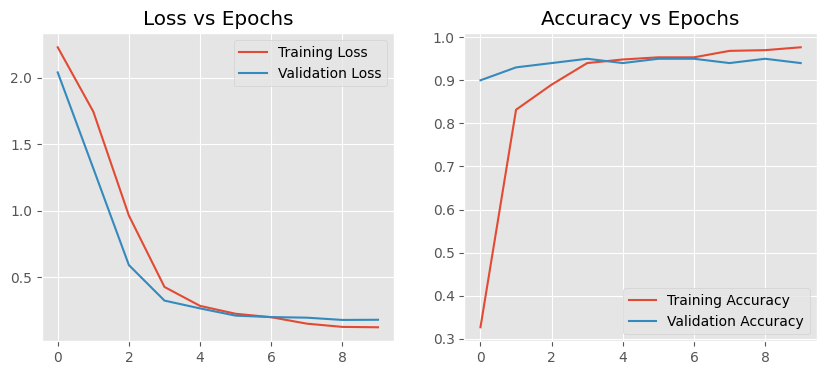

In [56]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')


#### Test the test data


In [58]:
# load the best saved model
best_model = torch.load('best_model_caltech256.pth')
resnet50.load_state_dict(best_model)

<All keys matched successfully>

In [60]:
test_accuracy = test(resnet50, test_data_loader, config.device)
print(f'Test Accuracy: {test_accuracy*100:.2f}')

Test Accuracy: 96.00


## Inference

In [65]:
def predict_image(image_path, model, device):
    image = Image.open(image_path)
    t_image = image_transforms['test'](image).float()
    t_image = t_image.view(1, t_image.shape[0], t_image.shape[1], t_image.shape[2])# reshape for the model
    t_image = t_image.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(t_image)
        prediction = torch.exp(outputs) # since the model outputs logsoftmax values
        
        # extract top three predictions
        top_probs, top_labels = prediction.topk(3)
        top_probs = top_probs.cpu().numpy().flatten()
        top_labels = top_labels.cpu().numpy().flatten()
        top_cls = [idx_to_class[label] for label in top_labels]

        for i in range(3):
            print(f'Prediction {i+1}: {top_cls[i]}, Probability: {top_probs[i]*100:.2f}%')
        

    fig = plt.figure(figsize=(4,4))
    plt.imshow(image)
    plt.axis('off')

Prediction 1: porcupine, Probability: 90.26%
Prediction 2: bear, Probability: 2.53%
Prediction 3: skunk, Probability: 2.24%


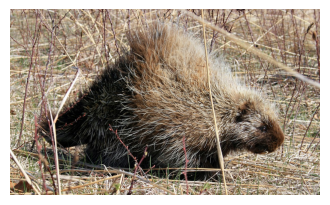

In [66]:
inference_image_path = "caltech256_subset/porcupine.jpg"
predict_image(inference_image_path, resnet50, config.device)